In [7]:
import matplotlib.patches as patches
from collections import defaultdict
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import base64
import json
import os
import io


#### Loading Dataset

In [2]:
def getJsonFiles(DataFolder,Type):
    """ Returns a list of JSON file paths from the specified folder and type."""
    Files = []
    subFolder = os.path.join(DataFolder, Type)
    for folder in os.listdir(subFolder):  
        folder_path = os.path.join(subFolder, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                Files.append(file_path)
    return Files

def getImage(JsonFilePath):
    """ Extracts the first image from a JSON file and returns it as a PIL Image object."""
    
    with open(JsonFilePath, 'r') as file:
        data = json.load(file)
    
    base64_image = data["pages"][0]["image"]["content"]
    image_data = base64.b64decode(base64_image)
    image = Image.open(BytesIO(image_data))

    return image

In [4]:
Files = getJsonFiles("../Data",'train')

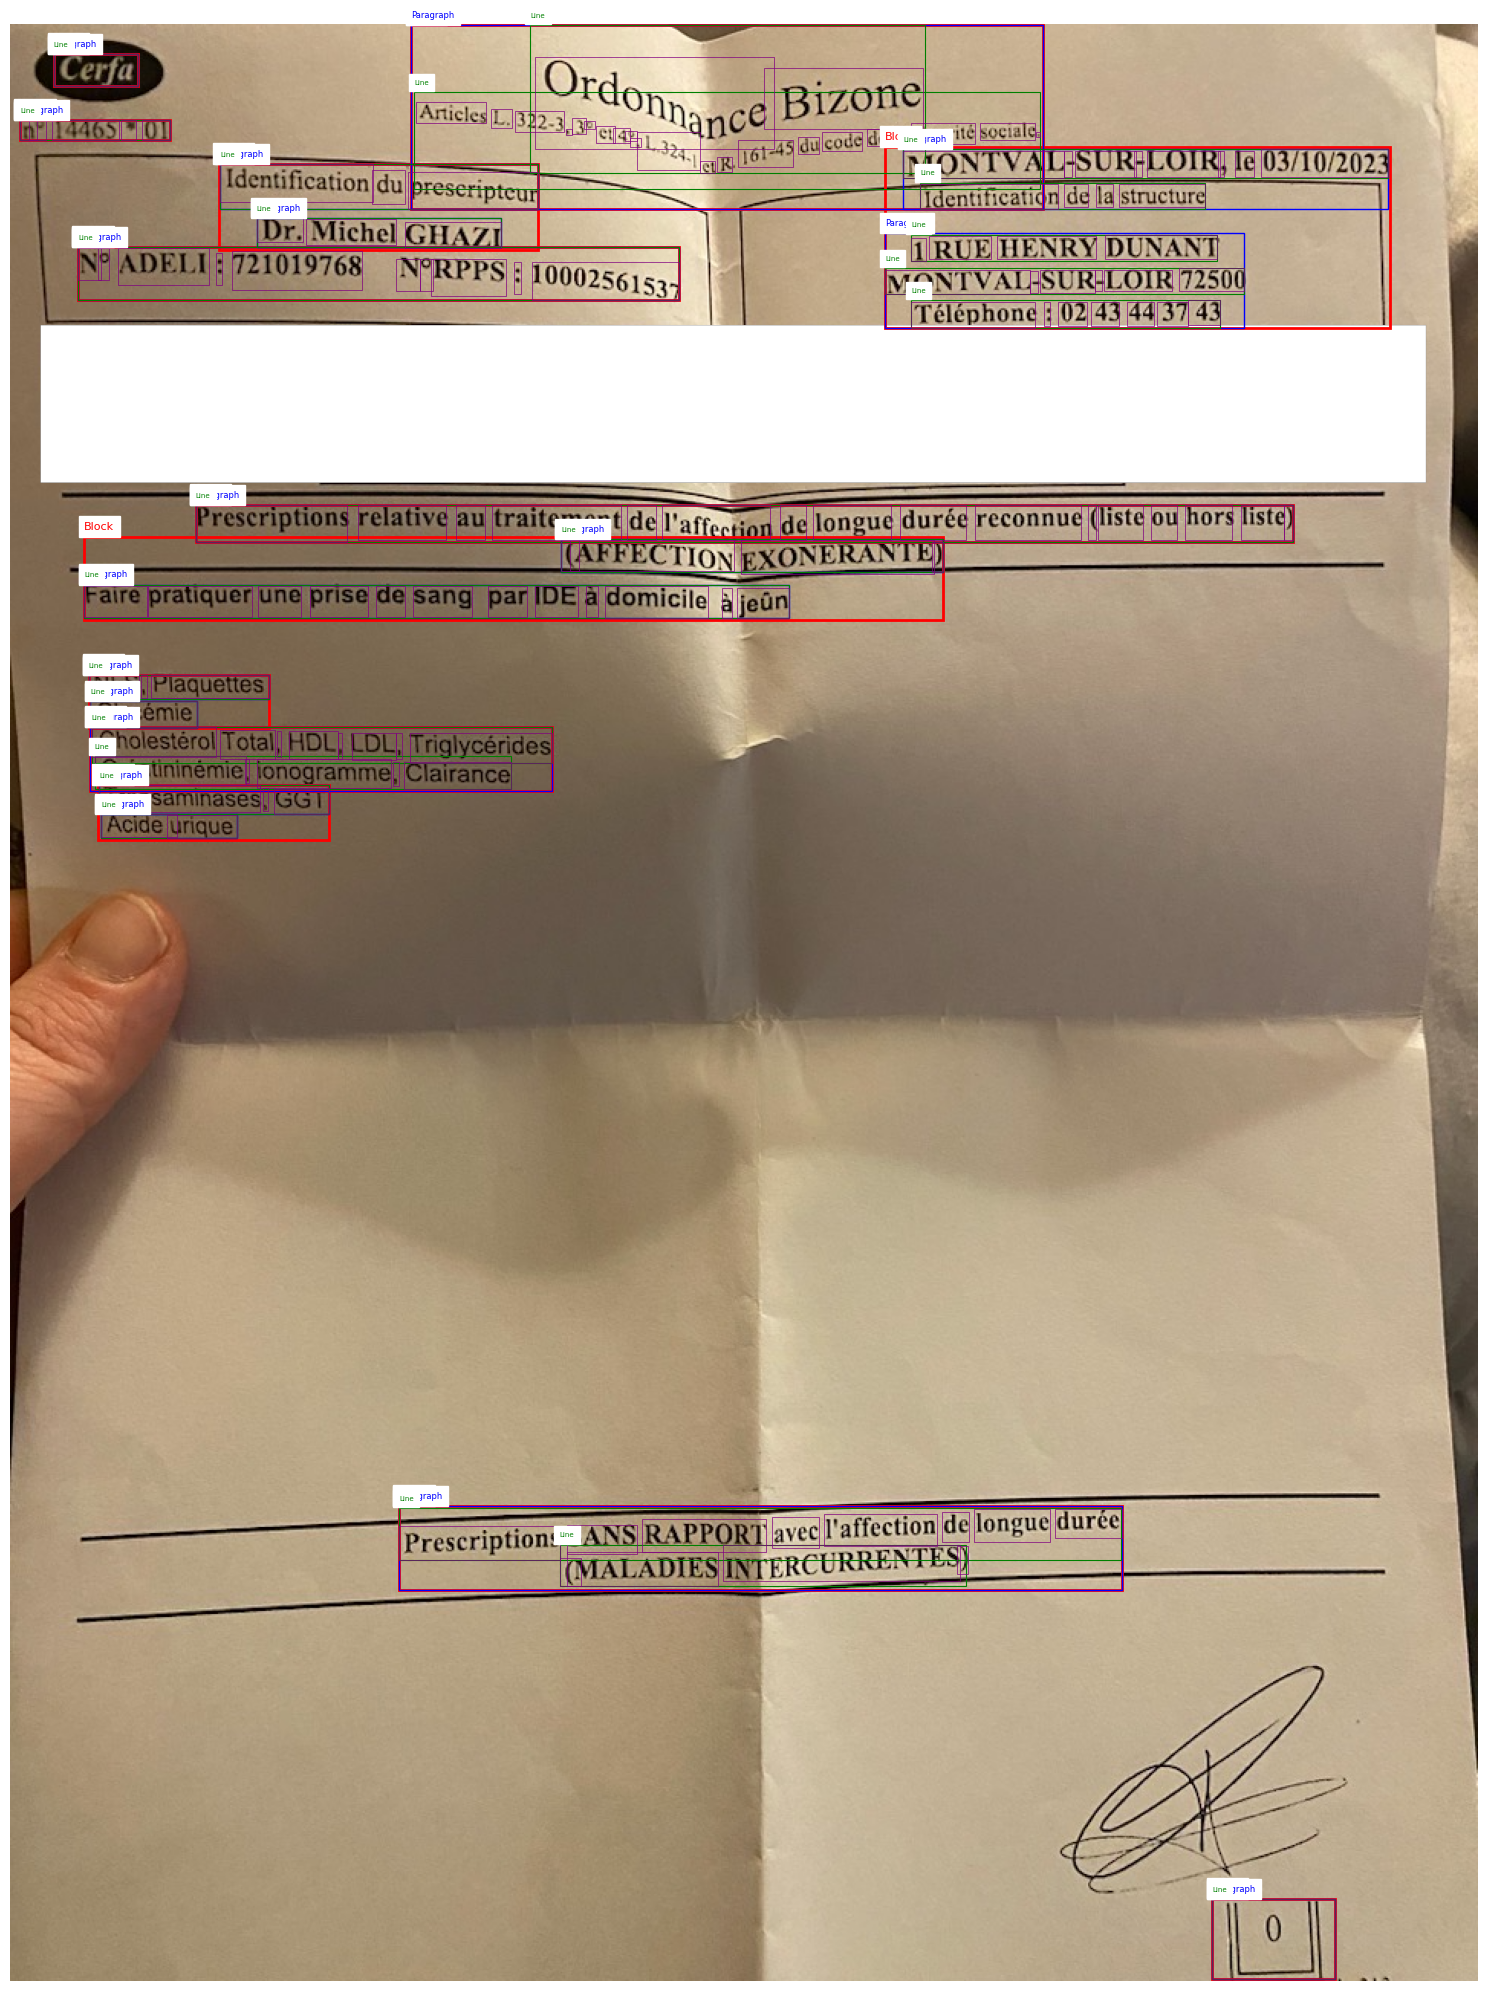

In [8]:

def load_document(json_path):
    """Load a JSON document from the specified path."""
    with open(json_path, "r") as f:
        doc = json.load(f)
    return doc

def decode_image(doc):
    """Decode the base64 image from the document."""
    image_base64 = doc["pages"][0]["image"]["content"]
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(io.BytesIO(image_bytes))
    return image

def get_bbox(vertices, image_width, image_height):
    """Convert normalizedVertices into a bounding box."""
    xs = [v.get('x', 0) * image_width for v in vertices]
    ys = [v.get('y', 0) * image_height for v in vertices]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return x_min, y_min, x_max - x_min, y_max - y_min  # x, y, width, height

def plot_document(json_path):
    """Plot the document with bounding boxes for blocks, paragraphs, lines, and tokens."""
    doc = load_document(json_path)
    image = decode_image(doc)
    image_width, image_height = image.size

    fig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow(image)
    ax.axis('off')

    # Plot blocks
    for block in doc["pages"][0].get("blocks", []):
        if "layout" in block and "boundingPoly" in block["layout"]:
            vertices = block["layout"]["boundingPoly"]["normalizedVertices"]
            x, y, w, h = get_bbox(vertices, image_width, image_height)
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y-5, "Block", color='red', fontsize=8, backgroundcolor='white')

    # Plot paragraphs
    for paragraph in doc["pages"][0].get("paragraphs", []):
        if "layout" in paragraph and "boundingPoly" in paragraph["layout"]:
            vertices = paragraph["layout"]["boundingPoly"]["normalizedVertices"]
            x, y, w, h = get_bbox(vertices, image_width, image_height)
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y-5, "Paragraph", color='blue', fontsize=6, backgroundcolor='white')

    # Plot lines
    for line in doc["pages"][0].get("lines", []):
        if "layout" in line and "boundingPoly" in line["layout"]:
            vertices = line["layout"]["boundingPoly"]["normalizedVertices"]
            x, y, w, h = get_bbox(vertices, image_width, image_height)
            rect = patches.Rectangle((x, y), w, h, linewidth=0.8, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y-5, "Line", color='green', fontsize=5, backgroundcolor='white')

    # Plot tokens
    for token in doc["pages"][0].get("tokens", []):
        if "layout" in token and "boundingPoly" in token["layout"]:
            vertices = token["layout"]["boundingPoly"]["normalizedVertices"]
            x, y, w, h = get_bbox(vertices, image_width, image_height)
            rect = patches.Rectangle((x, y), w, h, linewidth=0.5, edgecolor='purple', facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

plot_document("../Data/test/96de546e6b31daca/211bc8e0-0442-4be6-84cb-7d3345f9fe58.json")


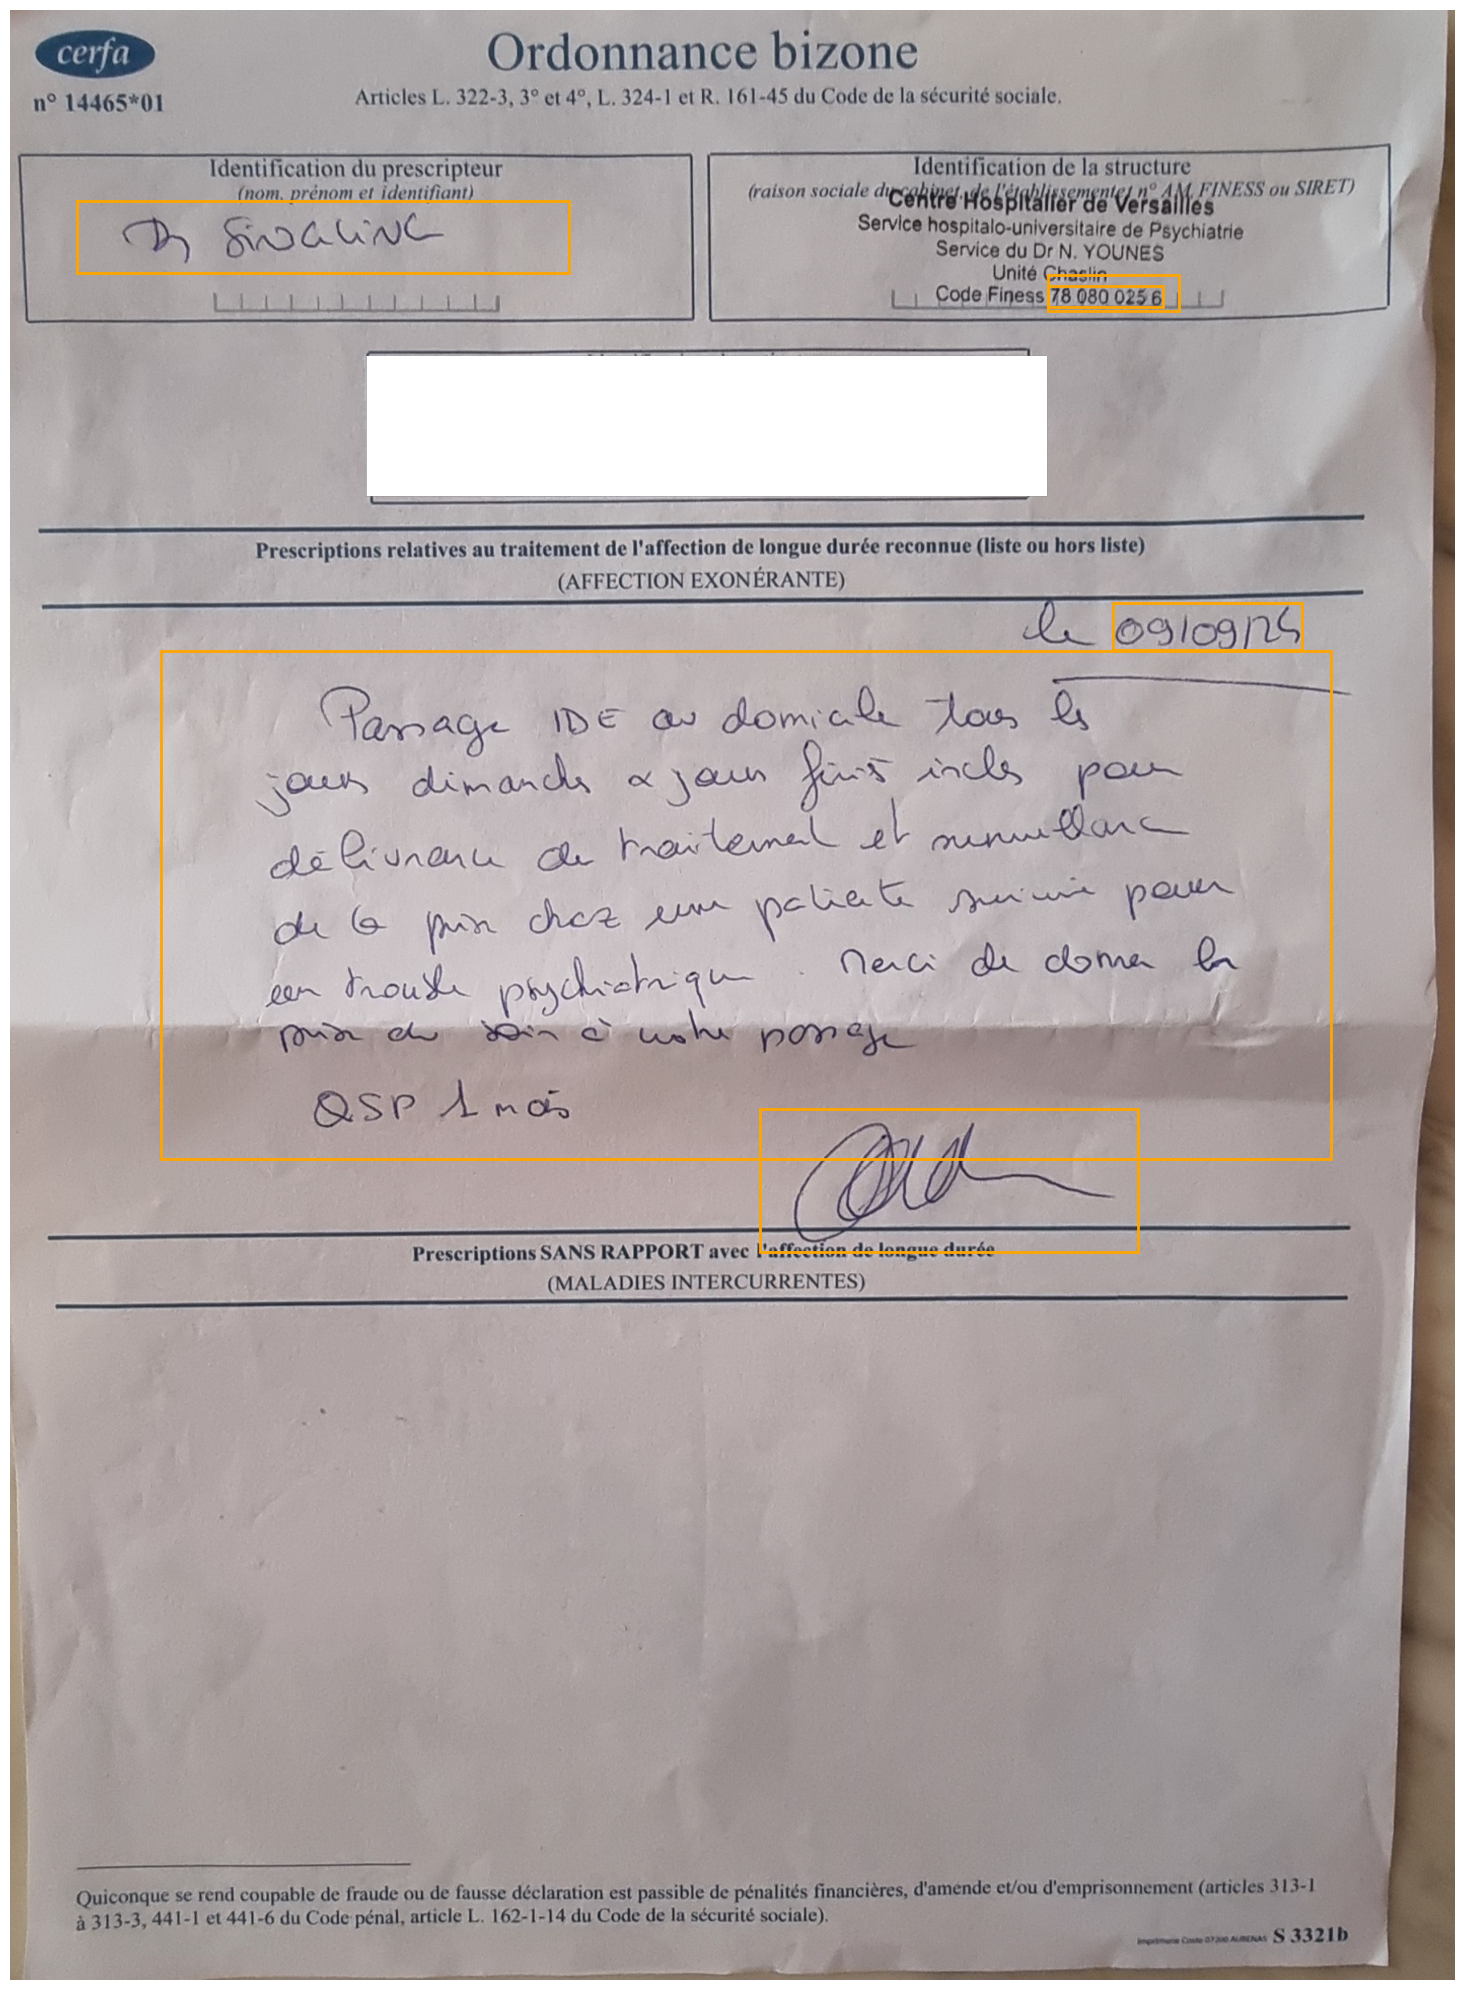

In [9]:
def plot_entities(json_path):
    """Plot the document with bounding boxes for entities."""
    doc = load_document(json_path)
    image = decode_image(doc)
    image_width, image_height = image.size

    fig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow(image)
    ax.axis('off')

    # Plot entities
    for entity in doc.get("entities", []):
        for page_ref in entity.get("pageAnchor", {}).get("pageRefs", []):
            if "boundingPoly" in page_ref:
                vertices = page_ref["boundingPoly"]["normalizedVertices"]
                x, y, w, h = get_bbox(vertices, image_width, image_height)
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='orange', facecolor='none')
                ax.add_patch(rect)

                # Display entity type if available
                label = entity.get("type", "Entity")
                

    plt.tight_layout()
    plt.show()

plot_entities("../Data/test/24c6b7320051721a/1435963b-528c-4d02-9d7e-2f75da33d9d2.json")


In [10]:

labels = [
    "Adresse-prescripteur",
    "Date-de-la-prescription",
    "Nom-du-medecin",
    "Numero-ADELI",
    "Numero-AM-Finess",
    "Numero-RPPS",
    "Signature",
    "Texte-manuscrit",
    "Texte-Signature",
    "Texte-soin-ALD",
    "Texte-soin-sans-ALD",
]

### Convert Data to Docltags

In [12]:
def entity_to_doctag(entity):
    """Convert an entity to a doctag format."""
    content = entity.get("mentionText", "")
    page_refs = entity.get("pageAnchor", {}).get("pageRefs", [])
    label = entity.get("type"," ")
    content = content.replace("\n", "")
    if page_refs:
        return (
            f"<text>"
            f"{label} : "
            f"{content}"
            f"</text>\n"
        )
    return ""

def convert_entities_to_doctags(json_data, labels):
    """Convert entities in JSON data to a doctag format."""
    entities = json_data.get("entities", [])
    
    # Group entities by their type
    entities_by_type = defaultdict(list)
    for entity in entities:
        entity_type = entity.get("type")
        entities_by_type[entity_type].append(entity)
    
    output = "<doctag>\n"
    for label in labels:
        if entities_by_type[label]:
            for entity in entities_by_type[label]:
                output += entity_to_doctag(entity)
        else:
            output += f"<text>{label} : </text>\n" 
            
    output += "</doctag>"
    return output

def convert_data_to_doctags(Files, labels):
    """Convert a list of JSON files to doctag format."""
    for filename in Files:
        try:
            with open(filename, "r", encoding="utf-8") as file:
                data = json.load(file)
            doctag_data = convert_entities_to_doctags(data, labels)

            new_filename = filename.replace(".json", ".txt")

            with open(new_filename, 'w',encoding="utf-8") as file:
                file.write(doctag_data)
        except:
            print(filename)
        

with open("../Data/test/96de546e6b31daca/211bc8e0-0442-4be6-84cb-7d3345f9fe58.json", "r", encoding="utf-8") as file:
    data = json.load(file)
    doctag_data = convert_entities_to_doctags(data, labels)
    print(doctag_data)


<doctag>
<text>Adresse-prescripteur : 1 RUE HENRY DUNANTMONTVAL-SUR-LOIR 72500</text>
<text>Date-de-la-prescription : 03/10/2023</text>
<text>Nom-du-medecin : Michel GHAZI</text>
<text>Numero-ADELI : 721019768</text>
<text>Numero-AM-Finess : </text>
<text>Numero-RPPS : 10002561537</text>
<text>Signature : ☑</text>
<text>Texte-manuscrit : </text>
<text>Texte-Signature : </text>
<text>Texte-soin-ALD : Faire pratiquer une prise de sang par IDE à domicile à jeûnNFS, PlaquettesGlycémieCholestérol Total, HDL, LDL, TriglycéridesCréatininémie, ionogramme, ClairanceTransaminases, GGTAcide urique</text>
<text>Texte-soin-sans-ALD : </text>
</doctag>


## Convert Data to Json for evaluation

In [13]:
def convert_entities_to_json(json_data, labels):
    """Convert entities in JSON data to a dictionary format based on specified labels."""
    entities = json_data.get("entities", [])
    
    entities_by_type = defaultdict(list)
    for entity in entities:
        entity_type = entity.get("type")
        entities_by_type[entity_type].append(entity)

    result = {}
    for label in labels:
        result[label] = entities_by_type.get(label, "") if entities_by_type[label] else ""

    return result

def convert_data_to_json(file_paths, labels):
    """Convert entities in multiple JSON files to a dictionary format based on specified labels."""
    for filename in file_paths:
        try:
            with open(filename, "r", encoding="utf-8") as file:
                data = json.load(file)

            doctag_data = convert_entities_to_json(data, labels)

            new_filename = filename.replace(".json", "_processed.json")

            with open(new_filename, 'w', encoding="utf-8") as file:
                json.dump(doctag_data, file, ensure_ascii=False, indent=2)

            print(f"Processed: {filename}")
        except Exception as e:
            print(f"Error in {filename}: {e}")

def convert_entities_to_json(json_data, labels):
    from collections import defaultdict

    entities = json_data.get("entities", [])
    entities_by_type = defaultdict(list)

    for entity in entities:
        entity_type = entity.get("type")
        entities_by_type[entity_type].append(entity.get('mentionText', ""))

    result = {}
    for label in labels:
        mentions = entities_by_type.get(label, [])
        result[label] = mentions[0] if mentions else ""

    return result


def convert_data_to_json(file_paths, labels):
    for filename in file_paths:
        try:
            with open(filename, "r", encoding="utf-8") as file:
                data = json.load(file)

            doctag_data = convert_entities_to_json(data, labels)

            new_filename = filename.replace(".json", "_processed.json")

            with open(new_filename, 'w', encoding="utf-8") as file:
                json.dump(doctag_data, file, ensure_ascii=False, indent=2)

            print(f"Processed: {filename}")
        except Exception as e:
            print(f"Error in {filename}: {e}")

            import json

def convert_data_to_json(file_paths, labels):
    """Convert entities in multiple JSON files to a dictionary format based on specified labels."""
    for filename in file_paths:
        try:
            with open(filename, "r", encoding="utf-8") as file:
                data = json.load(file)

            doctag_data = convert_entities_to_json(data, labels)

            new_filename = filename.replace(".json", "_processed.json")

            with open(new_filename, 'w', encoding="utf-8") as file:
                json.dump(doctag_data, file, ensure_ascii=False, indent=2)

        except Exception as e:
            print(f"Error in {filename}: {e}")


with open("../Data/test/96de546e6b31daca/211bc8e0-0442-4be6-84cb-7d3345f9fe58.json", "r", encoding="utf-8") as file:
    data = json.load(file)
    doctag_data = convert_entities_to_json(data, labels)
    print(doctag_data)

{'Adresse-prescripteur': '1 RUE HENRY DUNANT\nMONTVAL-SUR-LOIR 72500', 'Date-de-la-prescription': '03/10/2023', 'Nom-du-medecin': 'Michel GHAZI', 'Numero-ADELI': '721019768', 'Numero-AM-Finess': '', 'Numero-RPPS': '10002561537', 'Signature': '☑', 'Texte-manuscrit': '', 'Texte-Signature': '', 'Texte-soin-ALD': 'Faire pratiquer une prise de sang par IDE à domicile à jeûn\nNFS, Plaquettes\nGlycémie\nCholestérol Total, HDL, LDL, Triglycérides\nCréatininémie, ionogramme, Clairance\nTransaminases, GGT\nAcide urique', 'Texte-soin-sans-ALD': ''}


Perform Transformations

In [14]:
# Files = getJsonFiles("./Data","train")
# convert_data_to_doctags(Files,labels)

# Files = getJsonFiles("./Data","test")
# convert_data_to_doctags(Files,labels)


In [15]:
# Files = getJsonFiles("./Data","train")
# convert_data_to_json(Files,labels)

# Files = getJsonFiles("./Data","test")
# convert_data_to_json(Files,labels)